In [2]:
from scipy.stats import ttest_ind
from my_functions import *
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import my_functions
import importlib
importlib.reload(my_functions)


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# pip freeze > Projects\Project_2\requirements.txt

In [4]:
print(os.listdir("input"))

['stud_math.csv']


# DATA

In [5]:
data = pd.read_csv('input/stud_math.csv')

data.columns = ['school', 'sex', 'age', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time',
                'failures', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'fam_rel',
                'free_time', 'go_out', 'health', 'absences', 'score']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   fam_size            368 non-null    object 
 5   p_status            350 non-null    object 
 6   m_edu               392 non-null    float64
 7   f_edu               371 non-null    float64
 8   m_job               376 non-null    object 
 9   f_job               359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  travel_time         367 non-null    float64
 13  study_time          388 non-null    float64
 14  failures            373 non-null    float64
 15  school_sup          386 non-null    object 
 16  fam_sup 

In [6]:
data.head()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,studytime_granular,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


# PRIMARY PROCESSING DATA

In [7]:
# Заменим в соотв. колонках слова YES и NO на бинарные значения
data[['school_sup', 'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']] = data[[
    'school_sup', 'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']].apply(yn_to_binary)

# EDA

In [8]:
# посчитаем количество пустых значений по всем колонкам
data.apply(lambda x: x.isna().sum())
# Особенно выделяются колонки paid и p_status, где более 10% пустых значений

school                 0
sex                    0
age                    0
address               17
fam_size              27
p_status              45
m_edu                  3
f_edu                 24
m_job                 19
f_job                 36
reason                17
guardian              31
travel_time           28
study_time             7
failures              22
school_sup             9
fam_sup               39
paid                  40
activities            14
nursery               16
studytime_granular     7
higher                20
internet              34
romantic              31
fam_rel               27
free_time             11
go_out                 8
health                15
absences              12
score                  6
dtype: int64

## ЧИСЛОВЫЕ ПЕРЕМЕННЫЕ

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

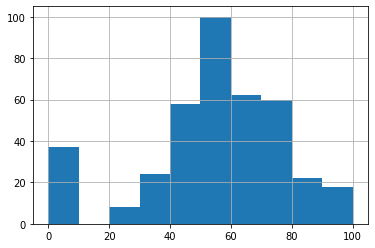

In [9]:
# Рассмотрим целевую колонку score
data.score.hist()
# data.score.value_counts(dropna=False)
data.score.describe()

# Возможно, стоит учесть тот факт, что солидная часть оценок равна нулям (37 из 389 не пустых), т.е., возможно, студент совсем не сдал экзамен, либо даже не допустился, что может говорить о тотальном отставании в учебе по каким-либо причинам. В остальном оценки распределены более менее нормально.
# Выбросов не наблюдается

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

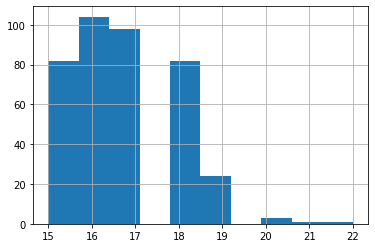

In [10]:
# колонка age : видим, что основная часть данных распределена между 15 и 18 годами
# небольшая доля значений 19
# совсем небольшая доля выше 19, возможно, совсем незначительная
# Однако все значения не выходят за рамки выбросов
data.age.hist()
data.age.value_counts(dropna=False)

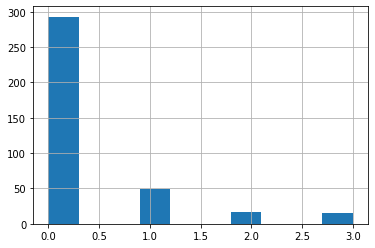

In [11]:
# Распределение неудач студентов сильно сдвинуто в сторону отсутствия неудач
data.failures.hist()

0.0      111
1.0        3
2.0       60
3.0        8
4.0       53
5.0        5
6.0       31
7.0        6
8.0       21
9.0        3
10.0      17
11.0       2
12.0      12
13.0       2
14.0      12
15.0       2
16.0       7
17.0       1
18.0       5
19.0       1
20.0       4
21.0       1
22.0       3
23.0       1
24.0       1
25.0       1
26.0       1
28.0       1
30.0       1
38.0       1
40.0       1
54.0       1
56.0       1
75.0       1
212.0      1
385.0      1
Name: absences, dtype: int64

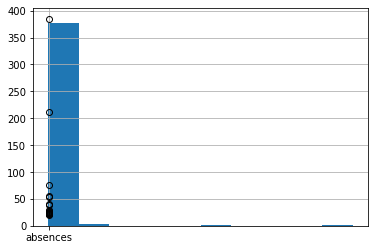

In [12]:
# изучим колонку absences
data.absences.hist()
data.boxplot(column=['absences'])
# Наблюдаем сильные выбросы
data.absences.value_counts().sort_index()

Границы выбросов: (-12.0, 20.0)


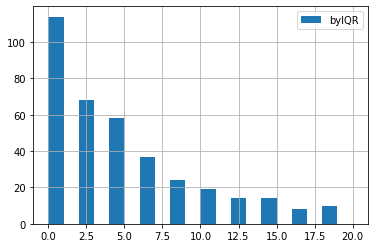

In [13]:
# выполним проверку absences на выбросы
perc25 = data.absences.quantile(0.25)
perc75 = data.absences.quantile(0.75)
IQR = perc75 - perc25
print(f'Границы выбросов: {perc25 - 1.5*IQR, perc75 + 1.5*IQR}')
data.absences.loc[data.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(label='byIQR', width=1)
plt.legend()
# однако остановимся на крайнем значении величины прогулов, где есть хотя бы несколько примеров, это 22 (3 примера)/ Посчитаем за выбросы значения выше 22 и избавимся от них
data = data.loc[data.absences <= 22]

# НОМИНАТИВНЫЕ ПЕРЕМЕННЫЕ

большинство номинативных переменных датасета имеют строго определенное количество уникальных значений от 2 до 5,   
количество их уникальных значений уже определено в легенде (мы уже заменили в некоторых колонках YES\NO на бинарные значения)

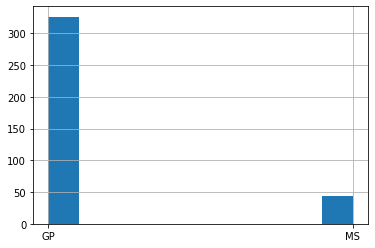

In [14]:
# Рассмотрим колонку school
data.school.hist()
# все данные поделены между двумя школами, причем по одной из них данных подавляющее количество

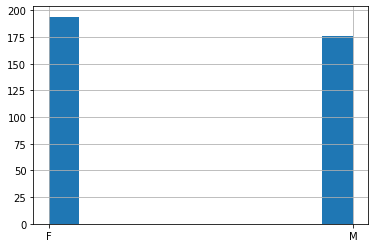

In [15]:
# по половому признаку студенты распределены нормально более-менее
data.sex.hist()

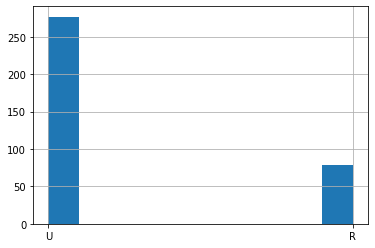

In [16]:
# Основная часть студентов городские
data.address.hist()

In [17]:
# Заполним пустые значения address на основе значений из travel_time
r_mean_time = data.groupby('address')['travel_time'].mean().loc['R']
u_mean_time = data.groupby('address')['travel_time'].mean().loc['U']
for i in data[data.address.isna()].index:
    if not np.isnan(data.travel_time.loc[i]):
        if abs(data.travel_time.loc[i] - r_mean_time) < abs(data.travel_time.loc[i] - u_mean_time):
            data.address.loc[i] = 'R'
        else:
            data.address.loc[i] = 'U'

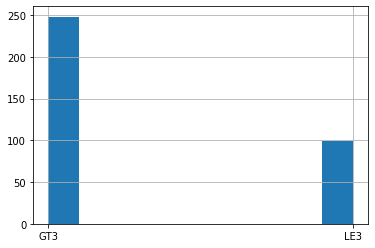

In [18]:
# Основная часть студентов живет в больших семьях
data.fam_size.hist()

In [19]:
# подавляющее большинство студентов живет с обоими родителями, так же значительное количество пустых значений
# Возможно, данный признак можно будет отбросить
data.p_status.value_counts(dropna=False)

T      298
NaN     40
A       32
Name: p_status, dtype: int64

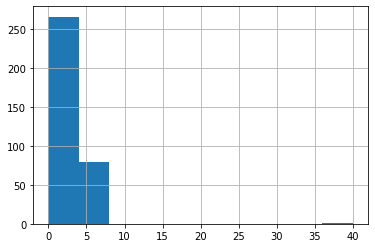

In [20]:
# нашли выброс-ошибку в колонке f_edu, выпадающий за приведенную в легенде шкалу
data.f_edu.hist()

In [21]:
# удалим выброс f_edu
data = data.loc[data.f_edu <= 4]

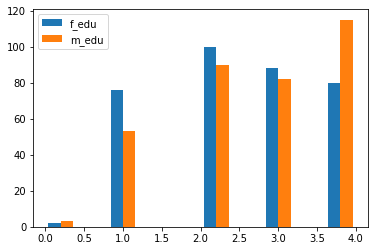

In [22]:
# Теперь рассмотрим сразу 2 схожих переменных m_edu и f_edu
# Распределение схожее.
# Незначительное количество родителей без образования
plt.hist([data.f_edu, data.m_edu], label=['f_edu', 'm_edu'])
plt.legend()

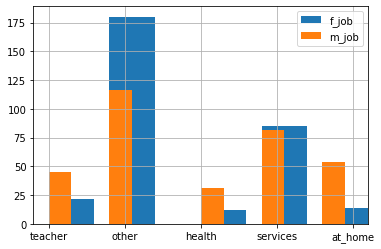

In [23]:
# рассмотрим сразу 2 схожих переменных f_job и m_job
data.f_job.hist(width=0.6, label='f_job')
data.m_job.hist(width=0.3, label='m_job')
plt.legend()

In [24]:
# По признакам reason, guardian, travel_time, study_time
display(data.reason.value_counts(dropna=False),
        data.guardian.value_counts(dropna=False),
        data.travel_time.value_counts(dropna=False),
        data.study_time.value_counts(dropna=False))

course        120
reputation     91
home           89
other          30
NaN            16
Name: reason, dtype: int64

mother    218
father     76
NaN        29
other      23
Name: guardian, dtype: int64

1.0    208
2.0     85
NaN     25
3.0     21
4.0      7
Name: travel_time, dtype: int64

2.0    169
1.0     93
3.0     54
4.0     25
NaN      5
Name: study_time, dtype: int64

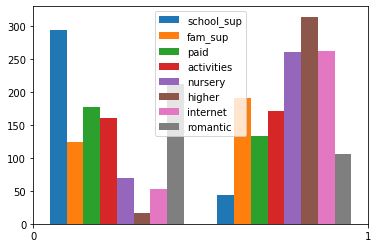

In [25]:
# группу признаков с бинарными значениями рассмотрим комплексно
bin_columns = ['school_sup', 'fam_sup', 'paid', 'activities',
               'nursery', 'higher', 'internet', 'romantic']
plt.hist([data.school_sup, data.fam_sup, data.paid, data.activities, data.nursery,
          data.higher, data.internet, data.romantic], alpha=1, bins=2, label=bin_columns)
plt.xticks([0, 1])
plt.legend()

# Видим наибольшие расхождения в корлонках school_sup , higher , internet, nursery - что может говорить о незначительности признаков.

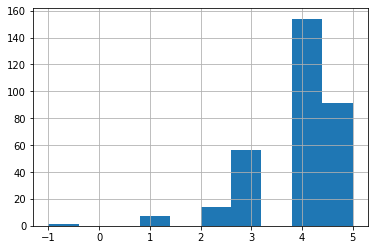

In [26]:
# Есть ошибка в колонке  fam_rel
data.fam_rel.hist()

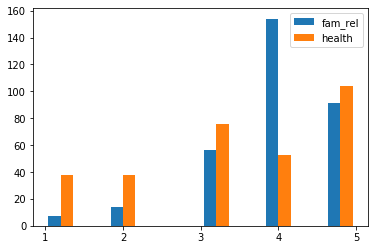

In [27]:
# удалим отрицательное значение в fam_rel
data = data.loc[data.fam_rel >= 0]
# и посмотрим распределение  fam_rel вместе с health_level
plt.hist([data.fam_rel, data.health], label=['fam_rel', 'health'])
plt.xticks([1, 2, 3, 4, 5])
plt.legend()

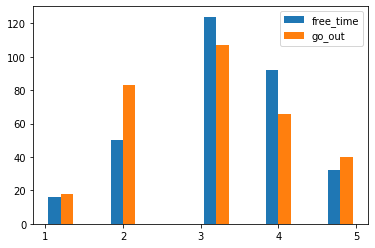

In [28]:
# free_time, go_out
plt.hist([data.free_time, data.go_out], label=['free_time', 'go_out'])
plt.xticks([1, 2, 3, 4, 5])
plt.legend()

# CORRELATIONS

In [29]:
# сформируем наборы признаков
all_columns = ['school', 'sex', 'age', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
               'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time',
               'failures', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery',
               'studytime_granular', 'higher', 'internet', 'romantic', 'fam_rel',
               'free_time', 'go_out', 'health', 'absences']

num_columns = ['age', 'failures', 'absences', 'score']

categ_columns = ['school', 'sex', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
                 'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time',
                 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery',
                 'studytime_granular', 'higher', 'internet', 'romantic', 'fam_rel',
                 'free_time', 'go_out', 'health']

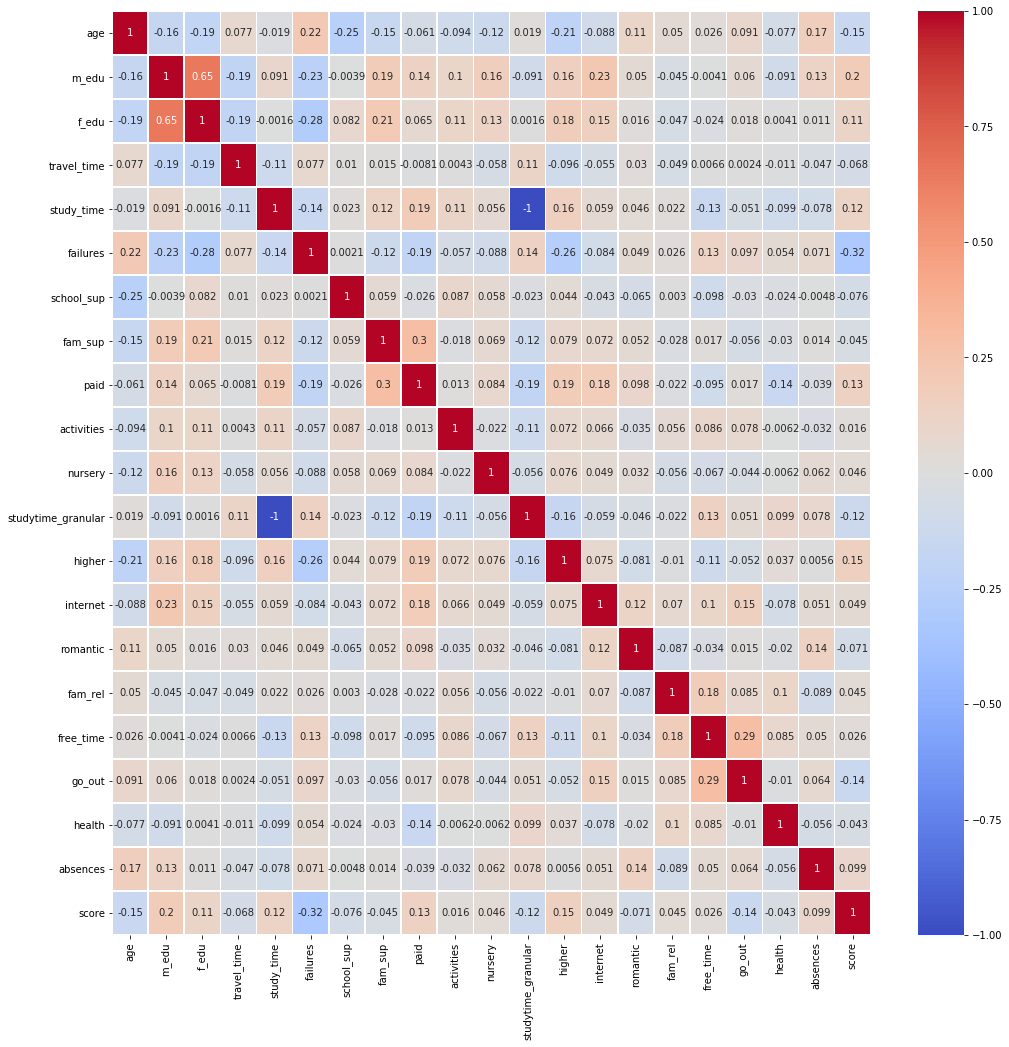

In [30]:
# рассмотрим глобальную корреляцию между колонками
correlation = data.corr()
fig, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

# ярко выражена полная корреляция между study_time и studytime_granular, предполагается исключение из анализа колонки studytime_granular
# довольно высокая корреляция между f_edu и m_edu, возможно стоит так же исключить один из них, но пока не будем.

data.drop('studytime_granular', errors='ignore', inplace=True, axis=1)
all_columns.remove('studytime_granular')
categ_columns.remove('studytime_granular')

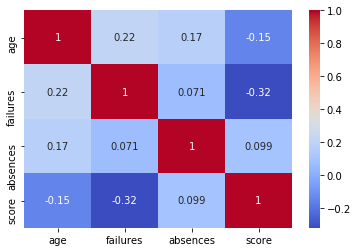

In [31]:
# как связаны числовые переменные друг с другом, и в частности с целевым значением
correlation = data[num_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
# Больше всего просматривается связь оценок с внеурочными неудачами. Вероятно, на студента может влиять состояние депрессии.

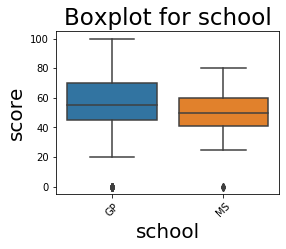

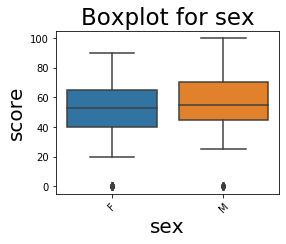

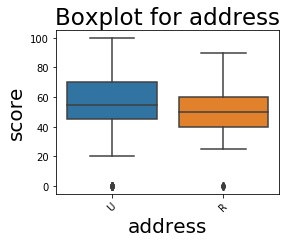

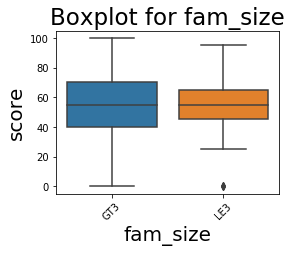

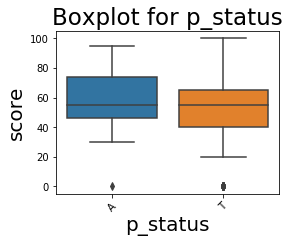

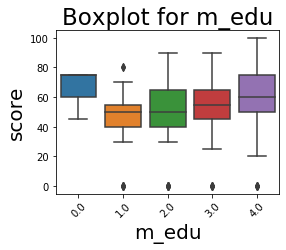

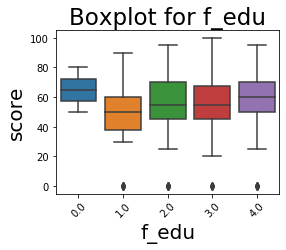

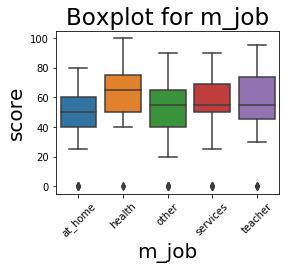

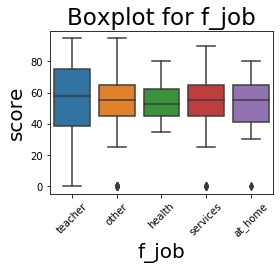

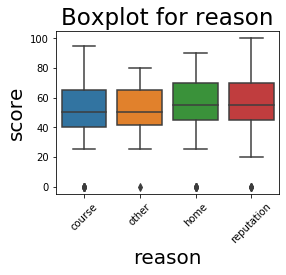

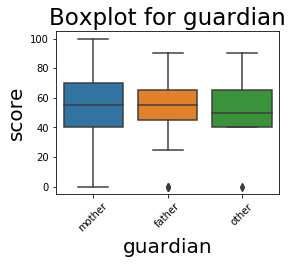

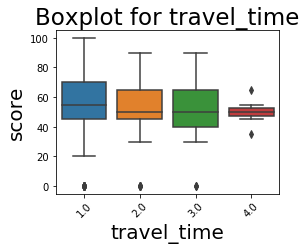

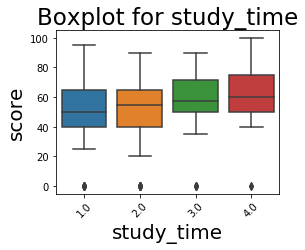

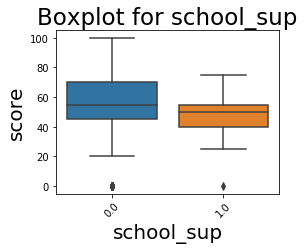

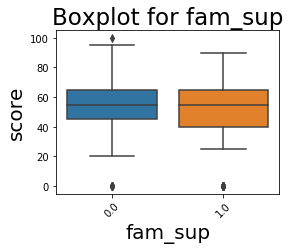

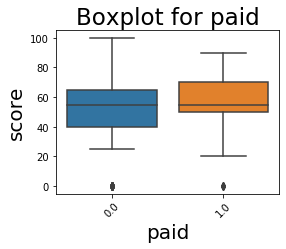

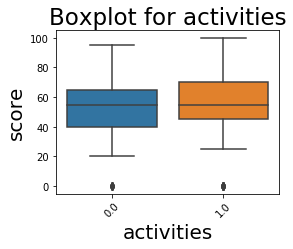

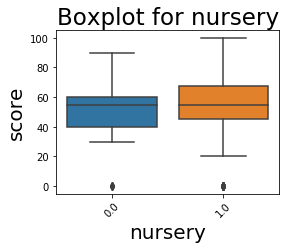

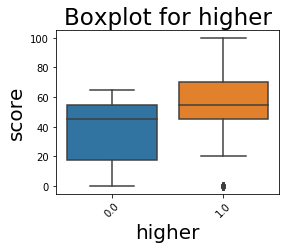

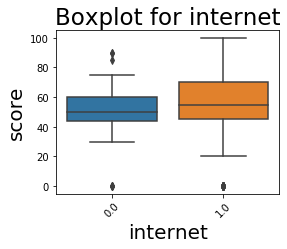

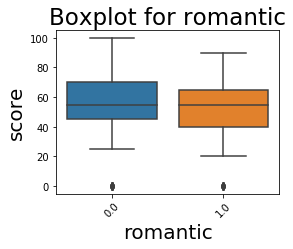

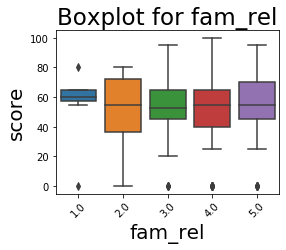

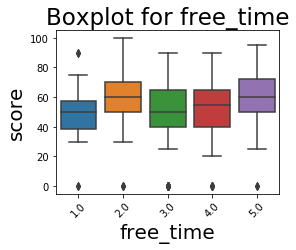

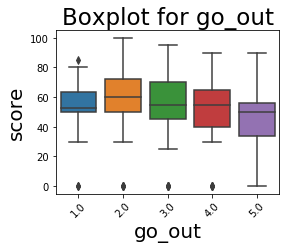

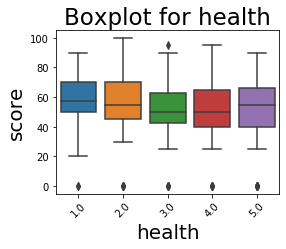

In [32]:
# рассмотрим графики зависимости оценок студентов от категориальных признаков
for col in categ_columns:
    get_boxplot(data, col, 'score')

In [33]:
# Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента c разными уровнями значимости alpha
alpha = 0.01
print(f'\nуровень значимости alpha равен {alpha}')
for col in all_columns:
    get_stat_dif(data, col, 'score', alpha)

alpha = 0.05
print(f'\nуровень значимости alpha равен {alpha}')
for col in all_columns:
    get_stat_dif(data, col, 'score', alpha)

alpha = 0.1
print(f'\nуровень значимости alpha равен {alpha}')
for col in all_columns:
    get_stat_dif(data, col, 'score', alpha)


уровень значимости alpha равен 0.01
Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки absences

уровень значимости alpha равен 0.05
Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки go_out
Найдены статистически значимые различия для колонки absences

уровень значимости alpha равен 0.1
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки fam_size
Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки failures


In [34]:
# Сохраним статистически важные признаки :
data_for_model = data.loc[:, ['m_edu', 'failures',
                              'paid', 'higher', 'go_out', 'absences']]
data_for_model.head()

,m_edu,failures,paid,higher,go_out,absences
0,4.0,0.0,0.0,1.0,4.0,6.0
1,1.0,0.0,0.0,1.0,3.0,4.0
2,1.0,3.0,NaN,1.0,2.0,10.0
3,4.0,0.0,1.0,1.0,2.0,2.0
4,3.0,0.0,1.0,1.0,2.0,4.0


# ВЫВОДЫ
## в результате EDA для анализа влияния параметров студентов на оценку по матиматике были получены следующие выводы:
В данных наличиствует некоторое количество пустых значений, особенно выделяются колонки paid и p_status, где более их более 10%   
   
Выбросы найдены в столбцах absences, f_edu, произведена очистка от выбросов   
   
Cолидная часть оценок равна 0 (37 из 389 не пустых, почти 10%), т.е., возможно, студент совсем не сдал экзамен, либо даже не допустился
   
Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, выявлены тестом Стьюдента на уровне значимости **ALPHA=0.05** и **при игнорировании значений NaN**:   
* m_edu
* failures
* paid
* higher
* go_out
* absences

In [37]:
data.score.

dtype('float64')